<a href="https://colab.research.google.com/github/anomara1/DrAhmedOmara/blob/main/Image_1001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Studying the sensitivity of several image-specific distances to the different Gaussian noise levels

# The Image-specific distances used are:
1. Traditional Image Quality Metrics

    Peak Signal-to-Noise Ratio (PSNR),
    Mean Squared Error (MSE),
    Structural Similarity Index (SSIM),
    Multi-Scale Structural Similarity Index (MS-SSIM),
    Universal Quality Index (UQI),
    Spatial Correlation Coefficient (SCC)

2. Spectral and Information-Theoretic Metrics

    Erreur Relative Globale Adimensionnelle de Synthèse (ERGAS),
    Relative Average Spectral Error (RASE),
    Spectral Angle Mapper (SAM),
    D_lambda (Spectral Distortion Measure),
    D_S (Spatial Distortion Measure),
    Quality with No Reference (QNR),
    Visual Information Fidelity (VIF),
    Shannon Entropy,
    Kullback-Leibler (KL) Divergence,

3. Distance-Based Metrics

    Euclidean Distance,
    Manhattan Distance (Cityblock Distance),
    Cosine Distance,
    Chebyshev Distance,
    Minkowski Distance (p=3),
    Bray-Curtis Distance,
    Hausdorff Distance (Fast Approximation),

4. Other Statistical & Gradient-Based Metrics

    Total Variation (TV) (Sum of absolute pixel differences),
    Gradient Magnitude Difference (Using Sobel filters),
    Histogram Intersection,
    Chi-Square Distance,





In [5]:
pip install sewar

  Preparing metadata (setup.py) ... done
  Created wheel for sewar: filename=sewar-0.4.6-py3-none-any.whl size=11421 sha256=cf7feda24c9d3566e652194b58cc2512df76c03b094cd079e9cbbcd118273429
  Stored in directory: /root/.cache/pip/wheels/87/f9/d9/6ec7e7b470df5ba0e317c6988ba7677a124ab220f5effea702
Successfully built sewar


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import sewar
from skimage import data, img_as_float, img_as_ubyte
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
from scipy.spatial.distance import euclidean, cityblock, cosine, chebyshev, minkowski, braycurtis
from scipy.stats import entropy
from skimage.color import rgb2gray, rgba2rgb
from scipy.linalg import norm
from skimage.filters import sobel
from skimage.measure import shannon_entropy
from skimage.util import random_noise
from tensorflow.keras.datasets import mnist

def preprocess_image(image, size=(256, 256)):
    image = img_as_float(image)
    if image.ndim == 3:
        if image.shape[2] == 4:
            image = rgba2rgb(image)
        image = rgb2gray(image)
    return image

def apply_gaussian_noise(image, var):
    noisy_image = random_noise(image, mode='gaussian', var=var)
    return noisy_image

def compute_metrics(original, modified):
    metrics = {}
    min_side = min(original.shape)
    win_size = min(7, min_side)
    if win_size % 2 == 0:
        win_size -= 1

    original_uint8 = img_as_ubyte(original)
    modified_uint8 = img_as_ubyte(modified)

    metrics['PSNR'] = float(psnr(original, modified, data_range=1))
    metrics['MSE'] = float(np.mean((original - modified) ** 2))
    metrics['SSIM'] = float(ssim(original, modified, data_range=1, win_size=win_size))
    metrics['MS-SSIM'] = float(sewar.msssim(original_uint8, modified_uint8))
    metrics['UQI'] = float(sewar.uqi(original_uint8, modified_uint8))
    metrics['SCC'] = float(sewar.scc(original_uint8, modified_uint8))
    metrics['VIF'] = float(sewar.vifp(original_uint8, modified_uint8))
    metrics['Euclidean'] = float(euclidean(original.ravel(), modified.ravel()))
    metrics['Manhattan'] = float(cityblock(original.ravel(), modified.ravel()))
    metrics['Cosine'] = float(cosine(original.ravel(), modified.ravel()))
    metrics['Chebyshev'] = float(chebyshev(original.ravel(), modified.ravel()))
    metrics['Minkowski'] = float(minkowski(original.ravel(), modified.ravel(), p=3))
    metrics['Bray-Curtis'] = float(braycurtis(original.ravel(), modified.ravel()))
    metrics['KL Divergence'] = float(entropy(original.ravel() + 1e-10, modified.ravel() + 1e-10))
    metrics['Shannon Entropy'] = float(shannon_entropy(modified))
    metrics['Total Variation'] = float(np.sum(np.abs(original - modified)))
    metrics['Gradient Magnitude'] = float(norm(sobel(original) - sobel(modified)))
    return metrics

# Load and preprocess images
categories = {
    "Natural": [preprocess_image(data.astronaut()), preprocess_image(data.camera()),
                 preprocess_image(data.coffee()), preprocess_image(data.chelsea()),
                 preprocess_image(data.clock()), preprocess_image(data.page()),
                 preprocess_image(data.coins()), preprocess_image(data.brick()),
                 preprocess_image(data.text()), preprocess_image(data.hubble_deep_field())],
    "Objects": [preprocess_image(data.checkerboard()), preprocess_image(data.grass()),
                 preprocess_image(data.moon()), preprocess_image(data.rocket()),
                 preprocess_image(data.horse()), preprocess_image(data.camera()),
                 preprocess_image(data.lily()), preprocess_image(data.cell()),
                 preprocess_image(data.camera())],
    "Textures": [preprocess_image(data.brick()), preprocess_image(data.text()),
                  preprocess_image(data.camera()), preprocess_image(data.page()),
                  preprocess_image(data.coins()), preprocess_image(data.chelsea()),
                  preprocess_image(data.clock()), preprocess_image(data.coffee()),
                  preprocess_image(data.hubble_deep_field())],
    "Handwritten": [preprocess_image(mnist.load_data()[0][0][i] / 255.0) for i in range(10)]
}

# Define noise levels and initialize results
noise_levels = np.linspace(0.001, 0.1, 10)  # Variance levels for Gaussian noise
metric_names = list(compute_metrics(np.zeros((10, 10), dtype=np.float32), np.zeros((10, 10), dtype=np.float32)).keys())

results = {category: {key: np.zeros(len(noise_levels)) for key in metric_names} for category in categories}

# Compute metrics for different noise levels
for category, images in categories.items():
    for image in images:
        for i, var in enumerate(noise_levels):
            noisy_image = apply_gaussian_noise(image, var)
            metrics = compute_metrics(image, noisy_image)
            for key in results[category]:
                results[category][key][i] += metrics[key]

# Normalize results
for category in results:
    for key in results[category]:
        results[category][key] /= len(categories[category])

# Plot the results
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(20, 40))
axes = axes.ravel()

for i, key in enumerate(results['Natural']):
    for category in results:
        axes[i].plot(noise_levels, results[category][key], marker='o', label=category)
    axes[i].set_title(key)
    axes[i].set_xlabel("Gaussian Noise Variance")
    axes[i].set_ylabel("Average Metric Value")
    axes[i].legend()
    axes[i].grid()

plt.tight_layout()
plt.show()
import sewar
from skimage import data, img_as_float, img_as_ubyte
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
from scipy.spatial.distance import euclidean, cityblock, cosine, chebyshev, minkowski, braycurtis
from scipy.stats import entropy
from skimage.color import rgb2gray, rgba2rgb
from scipy.linalg import norm
from skimage.filters import sobel
from skimage.measure import shannon_entropy
from skimage.util import random_noise
from tensorflow.keras.datasets import mnist

def preprocess_image(image, size=(256, 256)):
    image = img_as_float(image)
    if image.ndim == 3:
        if image.shape[2] == 4:
            image = rgba2rgb(image)
        image = rgb2gray(image)
    return image

def apply_gaussian_noise(image, var):
    noisy_image = random_noise(image, mode='gaussian', var=var)
    return noisy_image

def compute_metrics(original, modified):
    metrics = {}
    min_side = min(original.shape)
    win_size = min(7, min_side)
    if win_size % 2 == 0:
        win_size -= 1

    original_uint8 = img_as_ubyte(original)
    modified_uint8 = img_as_ubyte(modified)

    metrics['PSNR'] = float(psnr(original, modified, data_range=1))
    metrics['MSE'] = float(np.mean((original - modified) ** 2))
    metrics['SSIM'] = float(ssim(original, modified, data_range=1, win_size=win_size))
    metrics['MS-SSIM'] = float(sewar.msssim(original_uint8, modified_uint8))
    metrics['UQI'] = float(sewar.uqi(original_uint8, modified_uint8))
    metrics['SCC'] = float(sewar.scc(original_uint8, modified_uint8))
    metrics['VIF'] = float(sewar.vifp(original_uint8, modified_uint8))
    metrics['Euclidean'] = float(euclidean(original.ravel(), modified.ravel()))
    metrics['Manhattan'] = float(cityblock(original.ravel(), modified.ravel()))
    metrics['Cosine'] = float(cosine(original.ravel(), modified.ravel()))
    metrics['Chebyshev'] = float(chebyshev(original.ravel(), modified.ravel()))
    metrics['Minkowski'] = float(minkowski(original.ravel(), modified.ravel(), p=3))
    metrics['Bray-Curtis'] = float(braycurtis(original.ravel(), modified.ravel()))
    metrics['KL Divergence'] = float(entropy(original.ravel() + 1e-10, modified.ravel() + 1e-10))
    metrics['Shannon Entropy'] = float(shannon_entropy(modified))
    metrics['Total Variation'] = float(np.sum(np.abs(original - modified)))
    metrics['Gradient Magnitude'] = float(norm(sobel(original) - sobel(modified)))
    return metrics

# Load and preprocess images
categories = {
    "Natural": [preprocess_image(data.astronaut()), preprocess_image(data.camera()),
                 preprocess_image(data.coffee()), preprocess_image(data.chelsea()),
                 preprocess_image(data.clock()), preprocess_image(data.page()),
                 preprocess_image(data.coins()), preprocess_image(data.brick()),
                 preprocess_image(data.text()), preprocess_image(data.hubble_deep_field())],
    "Objects": [preprocess_image(data.checkerboard()), preprocess_image(data.grass()),
                 preprocess_image(data.moon()), preprocess_image(data.rocket()),
                 preprocess_image(data.horse()), preprocess_image(data.camera()),
                 preprocess_image(data.lily()), preprocess_image(data.cell()),
                 preprocess_image(data.camera())],
    "Textures": [preprocess_image(data.brick()), preprocess_image(data.text()),
                  preprocess_image(data.camera()), preprocess_image(data.page()),
                  preprocess_image(data.coins()), preprocess_image(data.chelsea()),
                  preprocess_image(data.clock()), preprocess_image(data.coffee()),
                  preprocess_image(data.hubble_deep_field())],
    "Handwritten": [preprocess_image(mnist.load_data()[0][0][i] / 255.0) for i in range(10)]
}

# Define noise levels and initialize results
noise_levels = np.linspace(0.001, 0.1, 10)  # Variance levels for Gaussian noise
metric_names = list(compute_metrics(np.zeros((10, 10), dtype=np.float32), np.zeros((10, 10), dtype=np.float32)).keys())

results = {category: {key: np.zeros(len(noise_levels)) for key in metric_names} for category in categories}

# Compute metrics for different noise levels
for category, images in categories.items():
    for image in images:
        for i, var in enumerate(noise_levels):
            noisy_image = apply_gaussian_noise(image, var)
            metrics = compute_metrics(image, noisy_image)
            for key in results[category]:
                results[category][key][i] += metrics[key]

# Normalize results
for category in results:
    for key in results[category]:
        results[category][key] /= len(categories[category])

# Plot the results
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(20, 40))
axes = axes.ravel()

for i, key in enumerate(results['Natural']):
    for category in results:
        axes[i].plot(noise_levels, results[category][key], marker='o', label=category)
    axes[i].set_title(key)
    axes[i].set_xlabel("Gaussian Noise Variance")
    axes[i].set_ylabel("Average Metric Value")
    axes[i].legend()
    axes[i].grid()

plt.tight_layout()
plt.show()


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)
<ipython-input-6-0d2290536cc0>:40: ComplexWarning: Casting complex values to real discards the imaginary part
  metrics['MS-SSIM'] = float(sewar.msssim(original_uint8, modified_uint8))
/usr/local/lib/python3.11/dist-packages/sewar/full_ref.py:349: RuntimeWarning: invalid value encountered in scalar divide
  return num/den
/usr/local/lib/python3.11/dist-packages/scipy/spatial/distance.py:647: RuntimeWarning: invalid value encountered in divide
  dist = 1.0 - uv / math.sqrt(uu * vv)
/usr/local/lib/python3.11/dist-packages/scipy/spatial/distance.py:1128: RuntimeWarning: invalid value encountered in scalar divide
  return l1_diff.sum() / l1_sum.sum()


KeyboardInterrupt: 

/usr/local/lib/python3.11/dist-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)
/usr/local/lib/python3.11/dist-packages/sewar/full_ref.py:349: RuntimeWarning: invalid value encountered in scalar divide
  return num/den
/usr/local/lib/python3.11/dist-packages/scipy/spatial/distance.py:647: RuntimeWarning: invalid value encountered in divide
  dist = 1.0 - uv / math.sqrt(uu * vv)
/usr/local/lib/python3.11/dist-packages/scipy/spatial/distance.py:1128: RuntimeWarning: invalid value encountered in scalar divide
  return l1_diff.sum() / l1_sum.sum()


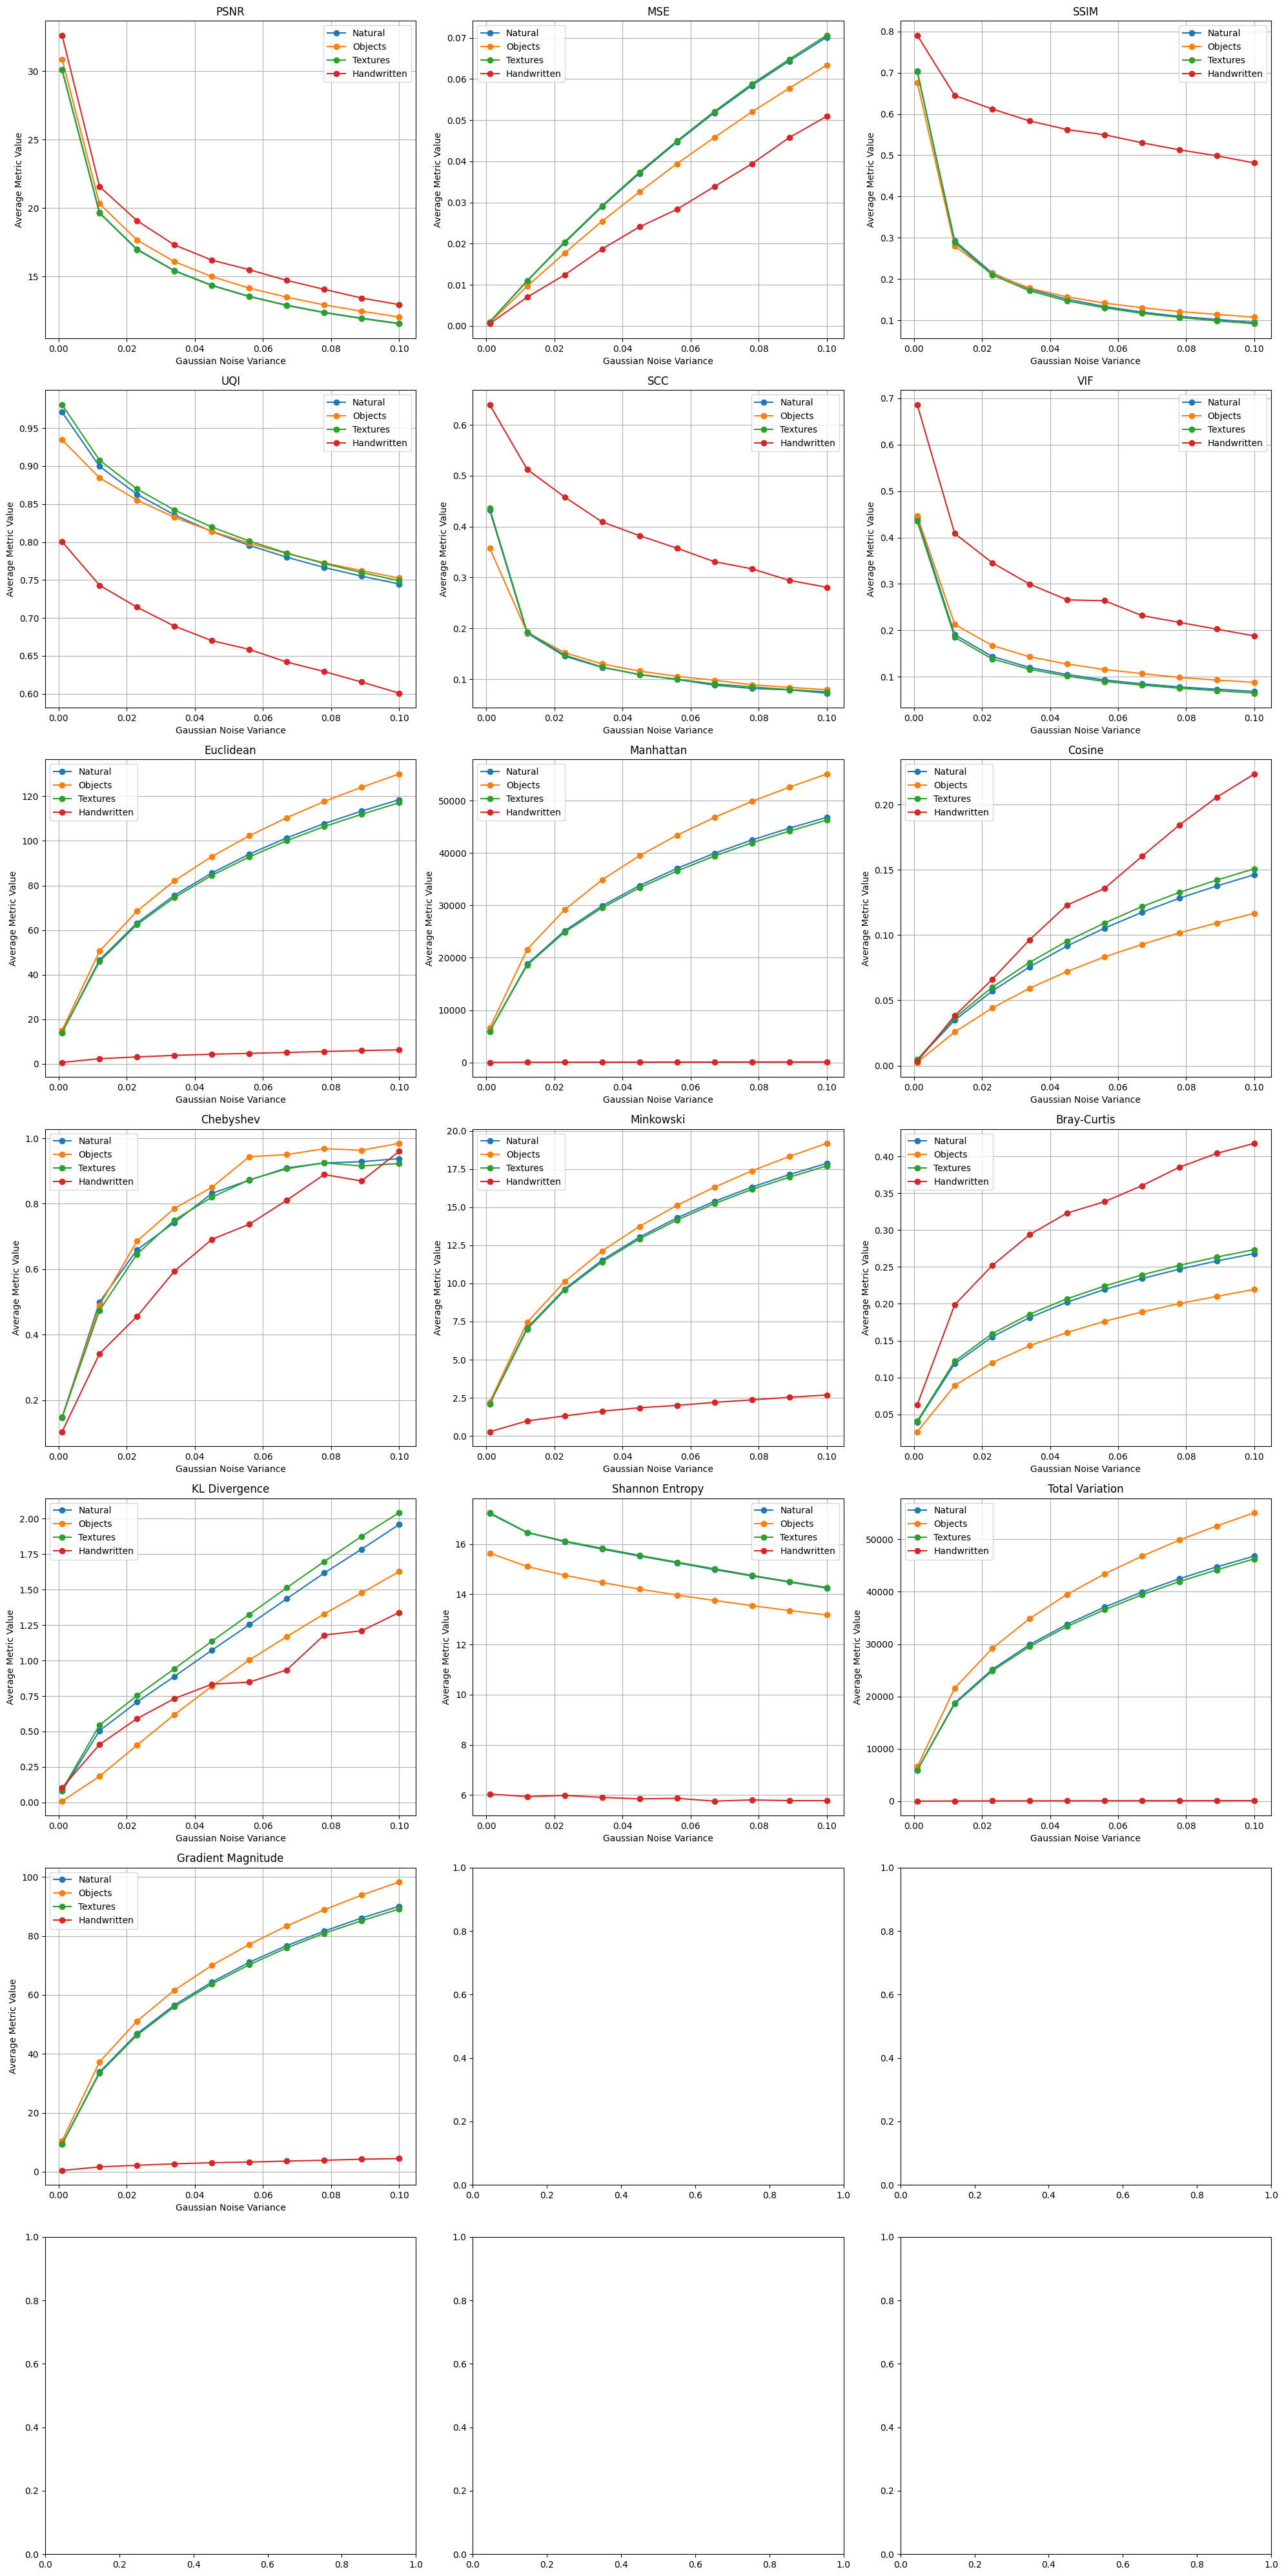

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import sewar
from skimage import data, img_as_float, img_as_ubyte
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
from scipy.spatial.distance import euclidean, cityblock, cosine, chebyshev, minkowski, braycurtis
from scipy.stats import entropy
from skimage.color import rgb2gray, rgba2rgb
from scipy.linalg import norm
from skimage.filters import sobel
from skimage.measure import shannon_entropy
from skimage.util import random_noise
from tensorflow.keras.datasets import mnist

def preprocess_image(image, size=(128, 128)):  # Reduced size for faster computation
    image = img_as_float(image)
    if image.ndim == 3:
        if image.shape[2] == 4:
            image = rgba2rgb(image)
        image = rgb2gray(image)
    return image

def apply_gaussian_noise(image, var):
    noisy_image = random_noise(image, mode='gaussian', var=var)
    return noisy_image

def compute_metrics(original, modified):
    metrics = {}
    min_side = min(original.shape)
    win_size = min(7, min_side)
    if win_size % 2 == 0:
        win_size -= 1

    original_uint8 = img_as_ubyte(original)
    modified_uint8 = img_as_ubyte(modified)

    metrics['PSNR'] = float(psnr(original, modified, data_range=1))
    metrics['MSE'] = float(np.mean((original - modified) ** 2))
    metrics['SSIM'] = float(ssim(original, modified, data_range=1, win_size=win_size))
    # metrics['MS-SSIM'] = float(sewar.msssim(original_uint8, modified_uint8))  # Commented out for speed
    metrics['UQI'] = float(sewar.uqi(original_uint8, modified_uint8))
    metrics['SCC'] = float(sewar.scc(original_uint8, modified_uint8))
    metrics['VIF'] = float(sewar.vifp(original_uint8, modified_uint8))
    metrics['Euclidean'] = float(euclidean(original.ravel(), modified.ravel()))
    metrics['Manhattan'] = float(cityblock(original.ravel(), modified.ravel()))
    metrics['Cosine'] = float(cosine(original.ravel(), modified.ravel()))
    metrics['Chebyshev'] = float(chebyshev(original.ravel(), modified.ravel()))
    metrics['Minkowski'] = float(minkowski(original.ravel(), modified.ravel(), p=3))
    metrics['Bray-Curtis'] = float(braycurtis(original.ravel(), modified.ravel()))
    metrics['KL Divergence'] = float(entropy(original.ravel() + 1e-10, modified.ravel() + 1e-10))
    metrics['Shannon Entropy'] = float(shannon_entropy(modified))
    metrics['Total Variation'] = float(np.sum(np.abs(original - modified)))
    metrics['Gradient Magnitude'] = float(norm(sobel(original) - sobel(modified)))
    return metrics

# Load and preprocess images
categories = {
    "Natural": [preprocess_image(data.astronaut()), preprocess_image(data.camera()),
                 preprocess_image(data.coffee()), preprocess_image(data.chelsea()),
                 preprocess_image(data.clock()), preprocess_image(data.page()),
                 preprocess_image(data.coins()), preprocess_image(data.brick()),
                 preprocess_image(data.text()), preprocess_image(data.hubble_deep_field())],
    "Objects": [preprocess_image(data.checkerboard()), preprocess_image(data.grass()),
                 preprocess_image(data.moon()), preprocess_image(data.rocket()),
                 preprocess_image(data.horse()), preprocess_image(data.camera()),
                 preprocess_image(data.lily()), preprocess_image(data.cell()),
                 preprocess_image(data.camera())],
    "Textures": [preprocess_image(data.brick()), preprocess_image(data.text()),
                  preprocess_image(data.camera()), preprocess_image(data.page()),
                  preprocess_image(data.coins()), preprocess_image(data.chelsea()),
                  preprocess_image(data.clock()), preprocess_image(data.coffee()),
                  preprocess_image(data.hubble_deep_field())],
    "Handwritten": [preprocess_image(mnist.load_data()[0][0][i] / 255.0) for i in range(10)]
}

# Define noise levels and initialize results
noise_levels = np.linspace(0.001, 0.1, 10)  # Variance levels for Gaussian noise
metric_names = list(compute_metrics(np.zeros((10, 10), dtype=np.float32), np.zeros((10, 10), dtype=np.float32)).keys())

results = {category: {key: np.zeros(len(noise_levels)) for key in metric_names} for category in categories}

# Compute metrics for different noise levels
for category, images in categories.items():
    for image in images:
        for i, var in enumerate(noise_levels):
            noisy_image = apply_gaussian_noise(image, var)
            metrics = compute_metrics(image, noisy_image)
            for key in results[category]:
                results[category][key][i] += metrics[key]

# Normalize results
for category in results:
    for key in results[category]:
        results[category][key] /= len(categories[category])

# Plot the results
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(20, 40))
axes = axes.ravel()

for i, key in enumerate(results['Natural']):
    for category in results:
        axes[i].plot(noise_levels, results[category][key], marker='o', label=category)
    axes[i].set_title(key)
    axes[i].set_xlabel("Gaussian Noise Variance")
    axes[i].set_ylabel("Average Metric Value")
    axes[i].legend()
    axes[i].grid()

plt.tight_layout()
plt.show()

In [7]:
pip install sewar


/usr/local/lib/python3.11/dist-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)
/usr/local/lib/python3.11/dist-packages/sewar/full_ref.py:349: RuntimeWarning: invalid value encountered in scalar divide
  return num/den
/usr/local/lib/python3.11/dist-packages/scipy/spatial/distance.py:647: RuntimeWarning: invalid value encountered in divide
  dist = 1.0 - uv / math.sqrt(uu * vv)
/usr/local/lib/python3.11/dist-packages/scipy/spatial/distance.py:1128: RuntimeWarning: invalid value encountered in scalar divide
  return l1_diff.sum() / l1_sum.sum()


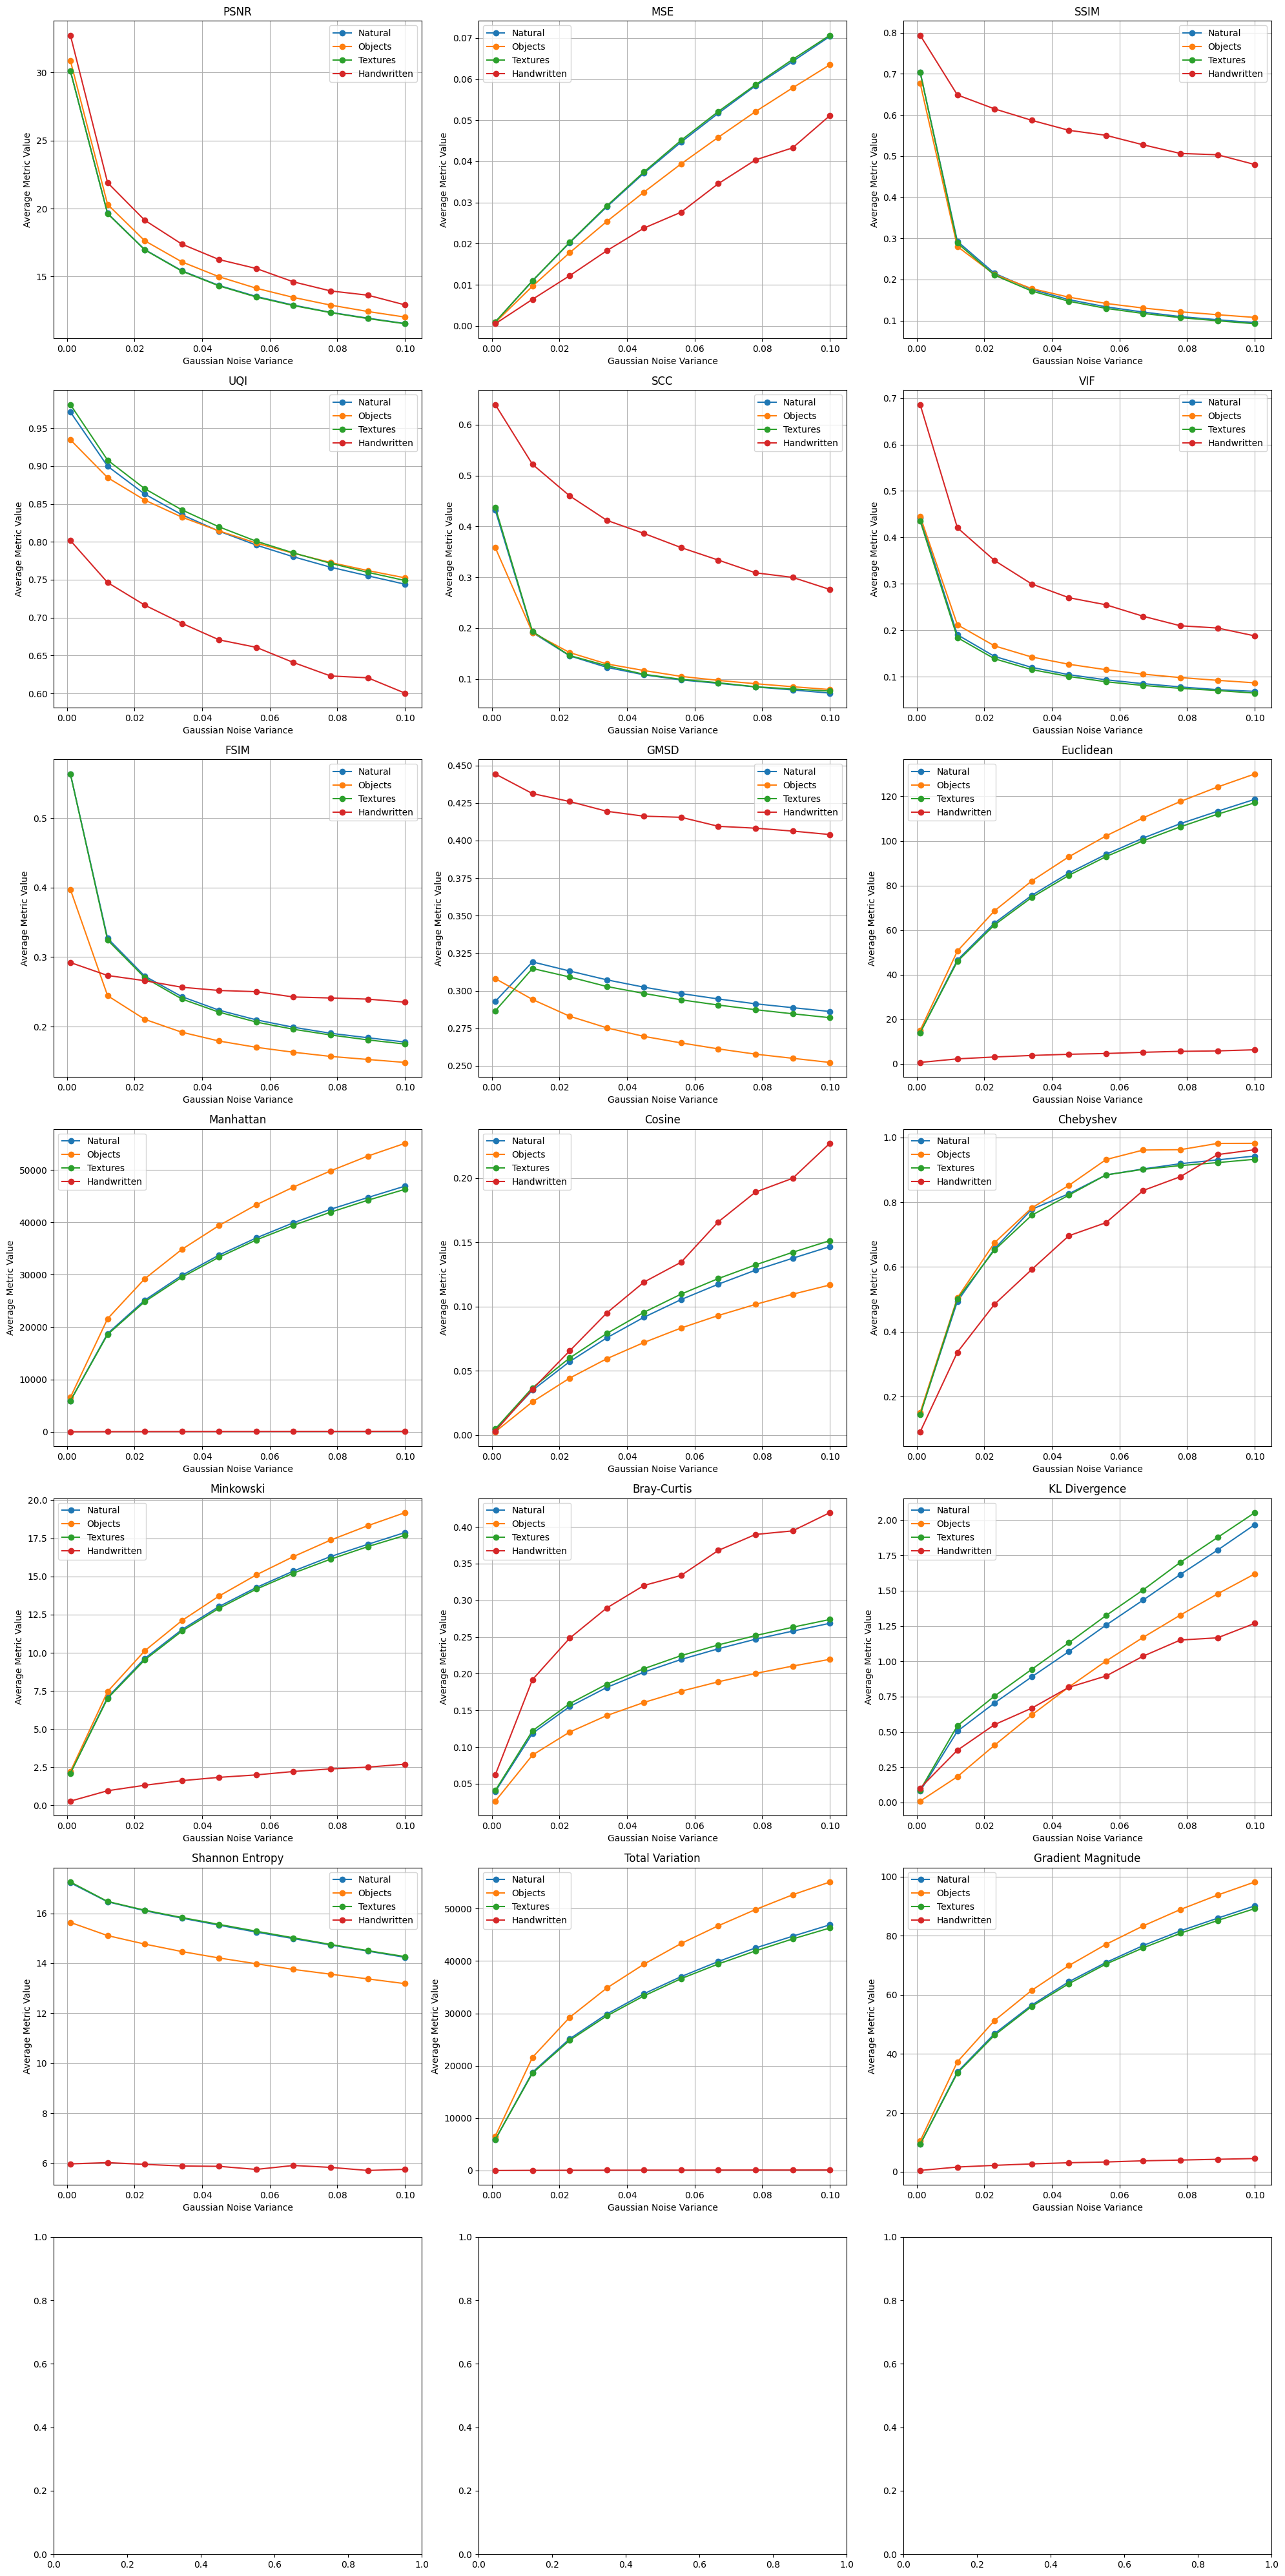

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import sewar
from skimage import data, img_as_float, img_as_ubyte
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
from scipy.spatial.distance import euclidean, cityblock, cosine, chebyshev, minkowski, braycurtis
from scipy.stats import entropy
from skimage.color import rgb2gray, rgba2rgb
from scipy.linalg import norm
from skimage.filters import sobel
from skimage.measure import shannon_entropy
from skimage.util import random_noise
from tensorflow.keras.datasets import mnist
from scipy.ndimage import gaussian_filter

def preprocess_image(image, size=(128, 128)):  # Reduced size for faster computation
    image = img_as_float(image)
    if image.ndim == 3:
        if image.shape[2] == 4:
            image = rgba2rgb(image)
        image = rgb2gray(image)
    return image

def apply_gaussian_noise(image, var):
    noisy_image = random_noise(image, mode='gaussian', var=var)
    return noisy_image

def compute_phase_congruency(image):
    """
    Compute phase congruency using gradient magnitude.
    This is a simplified version for demonstration purposes.
    """
    grad_x = sobel(image, axis=0)
    grad_y = sobel(image, axis=1)
    grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    return grad_magnitude

def compute_fsim(original, modified):
    """
    Compute Feature Similarity Index (FSIM) between two images.
    """
    # Compute phase congruency
    pc_original = compute_phase_congruency(original)
    pc_modified = compute_phase_congruency(modified)

    # Compute gradient magnitude
    grad_original = sobel(original)
    grad_modified = sobel(modified)

    # Compute similarity maps
    pc_similarity = (2 * pc_original * pc_modified + 1e-10) / (pc_original**2 + pc_modified**2 + 1e-10)
    grad_similarity = (2 * grad_original * grad_modified + 1e-10) / (grad_original**2 + grad_modified**2 + 1e-10)

    # Combine similarity maps
    similarity_map = pc_similarity * grad_similarity

    # Compute FSIM as the mean of the similarity map
    fsim = np.mean(similarity_map)
    return float(fsim)

def compute_gmsd(original, modified):
    """
    Compute Gradient Magnitude Similarity Deviation (GMSD).
    """
    original_grad = sobel(original)
    modified_grad = sobel(modified)
    gms = (2 * original_grad * modified_grad + 1e-10) / (original_grad**2 + modified_grad**2 + 1e-10)
    gmsd = np.std(gms)
    return float(gmsd)

def compute_metrics(original, modified):
    metrics = {}
    min_side = min(original.shape)
    win_size = min(7, min_side)
    if win_size % 2 == 0:
        win_size -= 1

    original_uint8 = img_as_ubyte(original)
    modified_uint8 = img_as_ubyte(modified)

    metrics['PSNR'] = float(psnr(original, modified, data_range=1))
    metrics['MSE'] = float(np.mean((original - modified) ** 2))
    metrics['SSIM'] = float(ssim(original, modified, data_range=1, win_size=win_size))
    # metrics['MS-SSIM'] = float(sewar.msssim(original_uint8, modified_uint8))  # Commented out for speed
    metrics['UQI'] = float(sewar.uqi(original_uint8, modified_uint8))
    metrics['SCC'] = float(sewar.scc(original_uint8, modified_uint8))
    metrics['VIF'] = float(sewar.vifp(original_uint8, modified_uint8))
    metrics['FSIM'] = compute_fsim(original, modified)  # Added custom FSIM
    metrics['GMSD'] = compute_gmsd(original, modified)  # Added GMSD (custom implementation)
    metrics['Euclidean'] = float(euclidean(original.ravel(), modified.ravel()))
    metrics['Manhattan'] = float(cityblock(original.ravel(), modified.ravel()))
    metrics['Cosine'] = float(cosine(original.ravel(), modified.ravel()))
    metrics['Chebyshev'] = float(chebyshev(original.ravel(), modified.ravel()))
    metrics['Minkowski'] = float(minkowski(original.ravel(), modified.ravel(), p=3))
    metrics['Bray-Curtis'] = float(braycurtis(original.ravel(), modified.ravel()))
    metrics['KL Divergence'] = float(entropy(original.ravel() + 1e-10, modified.ravel() + 1e-10))
    metrics['Shannon Entropy'] = float(shannon_entropy(modified))
    metrics['Total Variation'] = float(np.sum(np.abs(original - modified)))
    metrics['Gradient Magnitude'] = float(norm(sobel(original) - sobel(modified)))
    return metrics

# Load and preprocess images
categories = {
    "Natural": [preprocess_image(data.astronaut()), preprocess_image(data.camera()),
                 preprocess_image(data.coffee()), preprocess_image(data.chelsea()),
                 preprocess_image(data.clock()), preprocess_image(data.page()),
                 preprocess_image(data.coins()), preprocess_image(data.brick()),
                 preprocess_image(data.text()), preprocess_image(data.hubble_deep_field())],
    "Objects": [preprocess_image(data.checkerboard()), preprocess_image(data.grass()),
                 preprocess_image(data.moon()), preprocess_image(data.rocket()),
                 preprocess_image(data.horse()), preprocess_image(data.camera()),
                 preprocess_image(data.lily()), preprocess_image(data.cell()),
                 preprocess_image(data.camera())],
    "Textures": [preprocess_image(data.brick()), preprocess_image(data.text()),
                  preprocess_image(data.camera()), preprocess_image(data.page()),
                  preprocess_image(data.coins()), preprocess_image(data.chelsea()),
                  preprocess_image(data.clock()), preprocess_image(data.coffee()),
                  preprocess_image(data.hubble_deep_field())],
    "Handwritten": [preprocess_image(mnist.load_data()[0][0][i] / 255.0) for i in range(10)]
}

# Define noise levels and initialize results
noise_levels = np.linspace(0.001, 0.1, 10)  # Variance levels for Gaussian noise
metric_names = list(compute_metrics(np.zeros((10, 10), dtype=np.float32), np.zeros((10, 10), dtype=np.float32)).keys())

results = {category: {key: np.zeros(len(noise_levels)) for key in metric_names} for category in categories}

# Compute metrics for different noise levels
for category, images in categories.items():
    for image in images:
        for i, var in enumerate(noise_levels):
            noisy_image = apply_gaussian_noise(image, var)
            metrics = compute_metrics(image, noisy_image)
            for key in results[category]:
                results[category][key][i] += metrics[key]

# Normalize results
for category in results:
    for key in results[category]:
        results[category][key] /= len(categories[category])

# Plot the results
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(20, 40))
axes = axes.ravel()

for i, key in enumerate(results['Natural']):
    for category in results:
        axes[i].plot(noise_levels, results[category][key], marker='o', label=category)
    axes[i].set_title(key)
    axes[i].set_xlabel("Gaussian Noise Variance")
    axes[i].set_ylabel("Average Metric Value")
    axes[i].legend()
    axes[i].grid()

plt.tight_layout()
plt.show()